In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm

In [2]:
df_load = pd.read_csv('https://raw.githubusercontent.com/zdwhite/Thinkful-Unit-3/master/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df_load = df_load.dropna()

In [3]:
# I couldn't find another way to make this work reliably... to_numeric didn't work
for ind in range(len(df_load.TotalCharges)):
    if df_load.TotalCharges.iloc[ind] == ' ':
        df_load.TotalCharges.iloc[ind] = np.nan
#         print(ind)
    else:
        df_load.TotalCharges.iloc[ind] = float(df_load.TotalCharges.iloc[ind])

print('original number of rows:', len(df_load))
df_load = df_load.dropna()
print('corrected number of rows:', len(df_load))

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


original number of rows: 7043
corrected number of rows: 7032


In [13]:
# omit columns that aren't categorical
df_pre = df_load.loc[:, ~(df_load.columns).isin(['customerID', 'TotalCharges'])] 

# update columns with binary labels with 1 and 0 values
for col in ['Partner', 'Dependents', 'PhoneService', 'OnlineSecurity', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']:
    df_pre[col] = [1 if val == 'Yes' else 0 for val in df_pre[col]]
df_pre['Male'] = [1 if val == 'Male' else 0 for val in df_pre['gender']]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [14]:
# one_hot_encoder analog for columns that have multiple categories
df = pd.get_dummies(df_pre.loc[:, ~(df_pre.columns).isin(['gender'])])
df['TotalCharges'] = df_load['TotalCharges'].astype(float) # add continuous variable back in
df = df.dropna()

In [15]:
# from subsequent inspection of heatmap, omit the below features (with little effect except efficiency)
omit = ['Male','OnlineSecurity','StreamingTV', 'PaymentMethod_Bank transfer (automatic)','OnlineBackup_No internet service', 'PaymentMethod_Credit card (automatic)']
features = [col for col in df.columns if col not in omit]

In [16]:
target = 'Churn'
features.remove(target)

In [17]:
Y = df[target]#.apply(str)
X = df[features]
# X['TotalCharges'] = X['TotalCharges'].astype(float)

In [18]:
X.shape

(7032, 24)

In [19]:
X.describe()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,DeviceProtection,TechSupport,StreamingMovies,PaperlessBilling,MonthlyCharges,...,InternetService_Fiber optic,InternetService_No,OnlineBackup_No,OnlineBackup_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Electronic check,PaymentMethod_Mailed check,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,...,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,0.482509,0.298493,32.421786,0.903299,0.343857,0.290102,0.388367,0.592719,64.798208,...,0.440273,0.216155,0.438993,0.344852,0.551052,0.209329,0.239619,0.336320,0.228100,2283.300441
std,0.368844,0.499729,0.457629,24.545260,0.295571,0.475028,0.453842,0.487414,0.491363,30.085974,...,0.496455,0.411650,0.496300,0.475354,0.497422,0.406858,0.426881,0.472483,0.419637,2266.771362
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.800000
25%,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,35.587500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,401.450000
50%,0.000000,0.000000,0.000000,29.000000,1.000000,0.000000,0.000000,0.000000,1.000000,70.350000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1397.475000
75%,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.862500,...,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,3794.737500
max,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000,118.750000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8684.800000


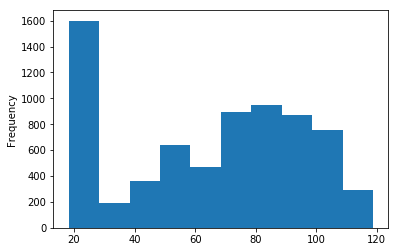

In [20]:
X['MonthlyCharges'].plot.hist()

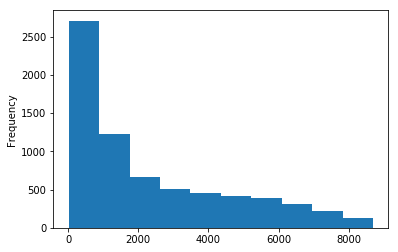

In [21]:
X['TotalCharges'].plot.hist()

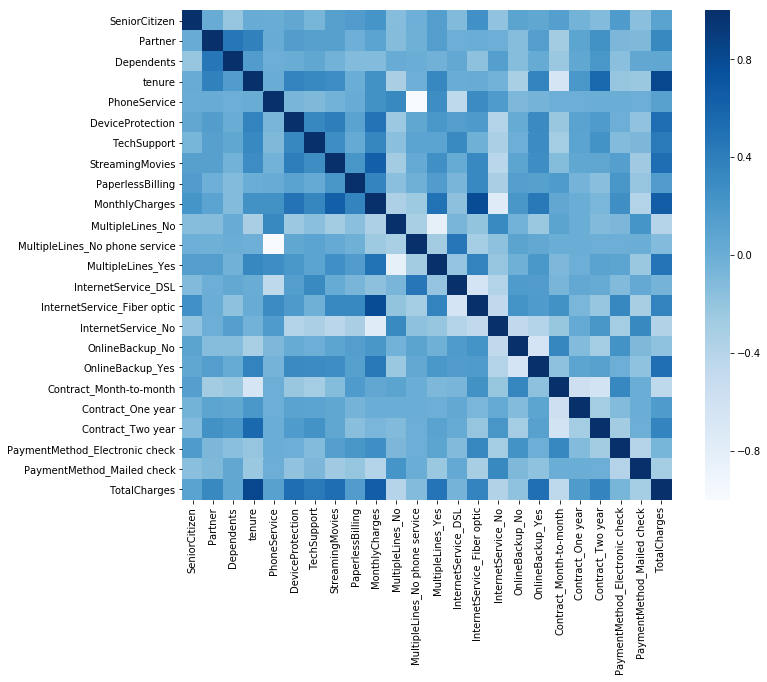

In [22]:
corrmat = X.corr()#alt_X_df.corr()

fig, ax = plt.subplots(1,1, figsize = (12,9))
sns.heatmap(corrmat, vmax = 1, square = True, annot=False,cmap='Blues')

In [151]:
# Shamlessly taken from https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
# I've coded dictionary versions of this same fnuctionality but this is nice and pythonic

# Create correlation matrix
corr_matrix = df.corr().abs() 
#Select upper triangle of correlation matrix

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# Drop features 
df = df.drop(to_drop, axis=1)

In [173]:
# prepare training and test sets (keep church and state in their own corners)
X_train,X_test,y_train,y_test=train_test_split(X,Y,random_state=3)

X_unfiltered = df.loc[:, ~(df.columns).isin([target])]
X_train_uf,X_test_uf,y_train_uf,y_test_uf=train_test_split(X_unfiltered,Y,random_state=3)

In [155]:
print('Guessing all 0s would result in an accuracy of: ', 1-sum(df[target])/len(df[target]))

Guessing all 0s would result in an accuracy of:  0.7342150170648465


In [153]:
# Vanilla Logistic Regression
np.asarray(X_train)
np.asarray(y_train)

logit = sm.Logit(y_train, X_train)
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.417176
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 5274
Model:                          Logit   Df Residuals:                     5253
Method:                           MLE   Df Model:                           20
Date:                Fri, 04 Jan 2019   Pseudo R-squ.:                  0.2859
Time:                        17:05:27   Log-Likelihood:                -2200.2
converged:                       True   LL-Null:                       -3081.1
                                        LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
SeniorCitizen                      0.2193      0.098      2.246     

/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [154]:
np.asarray(X_test)
pred_statsmod = result.predict(X_test)

# Code admission as 1 if probability is greater than .5.
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# Accuracy table.
table = pd.crosstab(y_test, pred_y_statsmod)

print('\n Accuracy by admission status')
print(table)
print('\n Percentage accuracy')
print((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum()))


 Accuracy by admission status
col_0     0    1
Churn           
0      1169  149
1       190  250

 Percentage accuracy
0.807167235495


In [160]:
# Lasso Logistic Regression
lr_l1 = LogisticRegression(penalty='l1')
lr_l1.fit(X_train, y_train)
print('cross val scores:', cross_val_score(lr_l1, X_train, y_train, cv=10))

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

cross val scores: [ 0.81060606  0.78409091  0.8125      0.79356061  0.79166667  0.80455408
  0.79696395  0.79886148  0.80645161  0.80988593]


In [161]:
lr_l1.score(X_test, y_test)

0.80830489192263932

In [174]:
# Lasso Logistic Regression
lr_l1 = LogisticRegression(penalty='l1')
lr_l1.fit(X_train_uf, y_train_uf)
print('cross val scores:', cross_val_score(lr_l1, X_train_uf, y_train_uf, cv=10))

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

cross val scores: [ 0.80871212  0.79924242  0.80113636  0.79924242  0.78787879  0.80645161
  0.79886148  0.79506641  0.81404175  0.80228137]


In [175]:
lr_l1.score(X_test_uf, y_test_uf)

0.80830489192263932

In [181]:
# Ridge Logistic Regression
lr_l2 = LogisticRegression(penalty='l2', C=1e10)
lr_l2.fit(X_train, y_train)
print('cross val scores:', cross_val_score(lr_l2, X_train, y_train, cv=10))

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

cross val scores: [ 0.81060606  0.79166667  0.8125      0.79545455  0.79356061  0.79886148
  0.79696395  0.80834915  0.80455408  0.80418251]


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [182]:
lr_l2.score(X_test, y_test)

0.80944254835039819

In [176]:
# Ridge Logistic Regression
lr_l2 = LogisticRegression(penalty='l2')
lr_l2.fit(X_train_uf, y_train_uf)
print('cross val scores:', cross_val_score(lr_l2, X_train_uf, y_train_uf, cv=10))

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

cross val scores: [ 0.8125      0.79734848  0.80871212  0.79545455  0.78598485  0.80265655
  0.79696395  0.79506641  0.81214421  0.80988593]


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [177]:
lr_l2.score(X_test_uf, y_test_uf)

0.80944254835039819

The three models performed similarly with and without pre-culling of features, and with various valus for C (regularization constant) actually.  This is not surprising as the feature set is not plagued with outliers, nor is it notably large.  Were the feature set larger/with stronger multicollinearity, LASSO might help cull the feature set. Similarly, if the features had notable outlies, Ridge might help reduce their impact. 